<font size="6">**IE 582 Statistical Learning for Data Mining - Homework 4**</font>

<font size="4">Mine Gazioğlu - Negin Kazemi - Umut Bütün</font>

---

# Data Preprocessing

**Import Libraries**

In [30]:
# Importing necessary libraries

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt # visualization
import matplotlib.pylab as plb # visualization
import seaborn as sns # visualization
#####from tqdm import tqdm_notebook as tqdm #to see a progress bar
import warnings # ignore deprecation warnings etc.
warnings.filterwarnings("ignore")
import time # dealing with time data
from datetime import datetime, timedelta # dealing with time data
import datetime as dt #datetime conversions and manipulations
from sklearn.linear_model import LogisticRegression

**Load Data**

In [31]:
# Load data with pandas

goals = pd.read_csv(r"C:\Users\ubtn\Desktop\IE-05\Data Mining\HW1\Data\goals.csv")
stats = pd.read_csv(r"C:\Users\ubtn\Desktop\IE-05\Data Mining\HW1\Data\stats.csv")
matches = pd.read_csv(r"C:\Users\ubtn\Desktop\IE-05\Data Mining\HW1\Data\matches.csv")
booking = pd.read_csv(r"C:\Users\ubtn\Desktop\IE-05\Data Mining\HW1\Data\booking.csv")
bets = pd.read_csv(r"C:\Users\ubtn\Desktop\IE-05\Data Mining\HW1\Data\bets.csv")

**Filter English Premier League Games**

In [32]:
# Filter English Premier League Games Alone
matches = matches[matches["league_id"] == 148]

**Convert epoch column in matches dataframe to datetime format**

In [33]:
# Convert epoch column to datetime format
start = datetime(1970, 1, 1)  # Unix epoch start time
matches['datetime'] = matches.epoch.apply(lambda x: start + timedelta(seconds=x))
# Drop epoch
matches.drop("epoch",axis = 1, inplace = True)

# Split datetime column to date and time columns
matches['Date'] = matches['datetime'].dt.strftime('%d/%m/%Y')
matches['Time'] = matches['datetime'].dt.strftime('%H:%M:%S')

**Remove the matches that haven't been played yet**

In [34]:
# Where home_score is NA
matches = matches[~matches["match_hometeam_score"].isna()]

**Rename some columns for convenience**

In [35]:
# Rename match_hometeam_score & match_awayteam_score to home_score & awayscore
matches.rename(columns = {"match_hometeam_score":"home_score","match_awayteam_score":"away_score"},inplace = True)

---

# Feature Engineering

**-** In this part we will create new features from combinations of columns we have<br>
**-** We have 2 tasks classification and regression<br>
**-** Some features we create will serve better for one of these tasks

**Create a Match Result Column that shows whether the game ended in draw, home win or away win**

We will not use this column as a feature but rather as a column to help build new features

In [36]:
# Create match result columns 
matches["match_result"] = np.where(matches['home_score'] == "not_played_h","Not Played",
                          np.where(matches['home_score'] > matches['away_score'],"Home", 
                          np.where(matches['home_score'] == matches['away_score'],"Draw","Away")))
# reset index
matches = matches.reset_index(drop = True)
# Show first 5 rows of the column
display(matches[["match_result"]].head())

,match_result
0,Away
1,Away
2,Draw
3,Away
4,Draw


<font size="3">**New Features**</font>

**1. Average number of goals for home team and away team in last 3 games**

Take the average of number of goals scored by home team and away team consecutively to yield 2 new columns as features

In [37]:
# Average number of goals for home team in last 3 games
matches["matches_3_average_home"] =  matches.groupby("match_hometeam_id")["home_score"].rolling(3,min_periods = 0).mean().reset_index(level=0, drop=True)
# Average number of goals for away team in last 3 games
matches["matches_3_average_away"] =  matches.groupby("match_awayteam_id")["away_score"].rolling(3,min_periods = 0).mean().reset_index(level=0, drop=True)

**2. Team average goals in last 5 games**

**-** Find average goals for the last 5 games for each team <br>
**-** The difference from above feature is team average scores for last 5 games are considered disregarding that the team played as home team or away team <br>
**-** Yields 2 columns for away and home teams as well

In [38]:
# Find average goals for the last 5 games for each team

# Filter matches dataframe to extract the necessary columns
team_average_goals_5_games = matches[["match_id","datetime","match_hometeam_id","home_score","match_awayteam_id","away_score"]]

# Melt this dataframe 2 times first to melt scores and second to melt team ids
# Melt scores
team_average_goals_5_games_melted_score = pd.melt(team_average_goals_5_games, id_vars=['datetime',"match_id","match_hometeam_id","match_awayteam_id"], value_vars = ["home_score","away_score"],var_name='Var1', value_name='Var1_value')
# Melt ids
team_average_goals_5_games_melted__teamid = pd.melt(team_average_goals_5_games, id_vars=['datetime',"match_id","home_score","away_score"], value_vars = ["match_hometeam_id","match_awayteam_id"],var_name='Var2', value_name='Var2_value')

# Merge the dataframes displayed above
melted = team_average_goals_5_games_melted_score.merge(team_average_goals_5_games_melted__teamid, on ="match_id")
melted = melted[["datetime_x","match_id","Var1","Var1_value","Var2","Var2_value"]]

# Drop values that are duplicated but not needed
melted =(melted[~((melted["Var2"] == "match_hometeam_id") & (melted["Var1"] == "away_score"))])
melted =(melted[~((melted["Var2"] == "match_awayteam_id") & (melted["Var1"] == "home_score"))])

# Sort values by datetime and team ids
melted = melted.sort_values(["Var2_value","datetime_x"])

# Perform rolling average 
melted["total_avg_goals"] =  melted.groupby("Var2_value")["Var1_value"].rolling(5,min_periods = 1).mean().reset_index(level=0, drop=True)
# Pivot the values
melted_pivot = melted.pivot(columns = "Var1",values="total_avg_goals" , index = "match_id")
melted_pivot.columns = ["team_avg_5_away_score","team_avg_5_away_home_score"]

matches = matches.merge(melted_pivot, on = "match_id")

**3. Total points in the last 3 games**

**-** For a match home team gets 3 points if wins, 1 points if draw, 0 points if loses and same goes for away team<br>
**-** This feature does not consider the number of goals but considers the outcome
**-** Yields 2 columns for home and away teams

In [39]:
# Create a column showing points for teams(win:3,loss:0,draw:1)
matches["home_points"] = matches["match_result"].apply(lambda x: 3 if x == "Home" else (1 if x== "Draw" else 0))
matches["away_points"] = matches["match_result"].apply(lambda x: 3 if x == "Away" else (1 if x== "Draw" else 0))

# Filter matches dataframe to extract the necessary columns
team_average_points_3_games = matches[["match_id","datetime","match_hometeam_id","match_awayteam_id","home_points","away_points"]]

# Melt this dataframe 2 times first 2 melt scores and second to melt team ids
# Melt scores
team_average_points_3_games_points = pd.melt(team_average_points_3_games, id_vars=['datetime',"match_id","match_hometeam_id","match_awayteam_id"], value_vars = ["home_points","away_points"],var_name='Var1', value_name='Var1_value')
# Melt ids
team_average_points_3_games_ids = pd.melt(team_average_points_3_games, id_vars=['datetime',"match_id","home_points","away_points"], value_vars = ["match_hometeam_id","match_awayteam_id"],var_name='Var2', value_name='Var2_value')

# Merge the dataframes displayed above
melted = team_average_points_3_games_points.merge(team_average_points_3_games_ids, on ="match_id")
melted = melted[["datetime_x","match_id","Var1","Var1_value","Var2","Var2_value"]]

# Drop values that are duplicated but not needed
melted =(melted[~((melted["Var2"] == "match_hometeam_id") & (melted["Var1"] == "away_points"))])
melted =(melted[~((melted["Var2"] == "match_awayteam_id") & (melted["Var1"] == "home_points"))])
# Sort values by datetime and team ids
melted = melted.sort_values(["Var2_value","datetime_x"])

# Perform rolling average 
melted["total_avg_points"] =  melted.groupby("Var2_value")["Var1_value"].rolling(3,min_periods = 1).mean().reset_index(level=0, drop=True)
# Pivot the values
melted_pivot = melted.pivot(columns = "Var1",values="total_avg_points" , index = "match_id")
melted_pivot.columns = ["team_avg_3_away_points","team_avg_3_away_home_points"]

matches = matches.merge(melted_pivot, on = "match_id")

**4. Total Points in a season for a team**

**-** Calculates based on English Premier League Seasons<br>
**-** Currently the data includes 2 seasons not containing all the games from both seasons<br>
**-** We will name these 2 seasons last season and this season<br>
**-** This will demonstrate the final points at the end of each season for each team.<br>

_Note that points may be more than English Premier League points in reality as the matches data 
includes additional matches such as Football League Cup as if it was Premier League._

Seperate Last Season's and This Season's Games

In [40]:
# Last season end date
last_season_end = "2019-08-08 23:00:00"
# Split current matches dataframe into last season and this season
# Last Season
last_season_df = matches[matches["datetime"] < last_season_end]
# This season
this_season_df =  matches[matches["datetime"] > last_season_end]

Point Calculation for Last Season

In [41]:
# Calculate last seasons's point for home and away teams(If win 3 points lose 0 points and draw 1 points)
# Home
last_season_df["Home_Point"] = last_season_df.match_result.apply(lambda x: 3 if x == "Home" else (1 if x== "Draw" else 0))
# Away
last_season_df["Away_Point"] = last_season_df.match_result.apply(lambda x: 3 if x == "Away" else (1 if x== "Draw" else 0))
# Create a dictionary that keeps point for team on home teams
home_dict = last_season_df.groupby("match_hometeam_id").sum()[["Home_Point"]].to_dict()
home_dict_last = home_dict["Home_Point"]
# Create a dictionary that keeps point for team on away teams
away_dict = last_season_df.groupby("match_awayteam_id").sum()[["Away_Point"]].to_dict()
away_dict_last = away_dict["Away_Point"]

# Then sum these dictionaries by their key(keys are id's of teams)
# This way we summed up home and away team points if the ids are the same
from collections import Counter 
total_dict_last = Counter(home_dict_last) + Counter(away_dict_last) 

Point Calculation for This Season

In [42]:
# Calculate this seasons's point for home and away teams(If win 3 points lose 0 points and draw 1 points)
# Home
this_season_df["Home_Point"] = this_season_df.match_result.apply(lambda x: 3 if x == "Home" else (1 if x== "Draw" else 0))
# Away
this_season_df["Away_Point"] = this_season_df.match_result.apply(lambda x: 3 if x == "Away" else (1 if x== "Draw" else 0))
# Create a dictionary that keeps point for team on home teams
home_dict = this_season_df.groupby("match_hometeam_id").sum()[["Home_Point"]].to_dict()
home_dict_this = home_dict["Home_Point"]
# Create a dictionary that keeps point for team on away teams
away_dict = this_season_df.groupby("match_awayteam_id").sum()[["Away_Point"]].to_dict()
away_dict_this = away_dict["Away_Point"]
# Then sum these dictionaries by their key(keys are id's of teams)
# This way we summed up home and away team points if the ids are the same
from collections import Counter 
total_dict_this = Counter(home_dict_this) + Counter(away_dict_this) 

In [43]:
# Add old and new season point totals as features
matches["old_season_points_home"] = matches.match_hometeam_id.map(total_dict_last)
matches["old_season_points_away"] = matches.match_awayteam_id.map(total_dict_last)

matches["this_season_points_home"] = matches.match_hometeam_id.map(total_dict_this)
matches["this_season_points_away"] = matches.match_awayteam_id.map(total_dict_this)

**5. Average number of goals by home and away teams**(Regression)

**-** Very similar to the above feature<br>
**-** Find average number of goals by each team divided to seasons

In [44]:
# Last season end date
last_season_end = "2019-08-08 23:00:00"
# Split current matches dataframe into last season and this season
# Last Season
last_season_df = matches[matches["datetime"] < last_season_end]
# This season
this_season_df =  matches[matches["datetime"] > last_season_end]

In [45]:
#LAst Season
a = pd.melt(last_season_df, id_vars = ['datetime',"match_id","match_hometeam_id","match_awayteam_id"], value_vars = ["home_score","away_score"], var_name = "Var1",value_name='Var1_value')
b = pd.melt(last_season_df, id_vars=['datetime',"match_id","home_score","away_score"], value_vars = ["match_hometeam_id","match_awayteam_id"],var_name='Var2', value_name='Var2_value')
last_season = a.merge(b,on = "match_id")
last_season = last_season[["datetime_x","match_id","Var1","Var1_value","Var2","Var2_value"]]

last_season.sort_values(["datetime_x","Var2_value"])

# Drop values that are duplicated but not needed
last_season =(last_season[~((last_season["Var2"] == "match_hometeam_id") & (last_season["Var1"] == "away_score"))])
last_season =(last_season[~((last_season["Var2"] == "match_awayteam_id") & (last_season["Var1"] == "home_score"))])


goals_last_season_dict = last_season.groupby("Var2_value")["Var1_value"].mean().to_dict()


In [46]:
# This Season
a = pd.melt(this_season_df, id_vars = ['datetime',"match_id","match_hometeam_id","match_awayteam_id"], value_vars = ["home_score","away_score"], var_name = "Var1",value_name='Var1_value')
b = pd.melt(this_season_df, id_vars=['datetime',"match_id","home_score","away_score"], value_vars = ["match_hometeam_id","match_awayteam_id"],var_name='Var2', value_name='Var2_value')
this_season = a.merge(b,on = "match_id")
this_season = this_season[["datetime_x","match_id","Var1","Var1_value","Var2","Var2_value"]]

this_season.sort_values(["datetime_x","Var2_value"])

# Drop values that are duplicated but not needed
this_season =(this_season[~((this_season["Var2"] == "match_hometeam_id") & (this_season["Var1"] == "away_score"))])
this_season =(this_season[~((this_season["Var2"] == "match_awayteam_id") & (this_season["Var1"] == "home_score"))])


goals_this_season_dict = this_season.groupby("Var2_value")["Var1_value"].mean().to_dict()

In [47]:
matches["last_season_goals_home_total"] = matches["match_hometeam_id"].map(goals_last_season_dict)
matches["last_season_goals_away_total"] = matches["match_awayteam_id"].map(goals_last_season_dict)
matches["this_season_goals_home_total"] = matches["match_hometeam_id"].map(goals_this_season_dict)
matches["this_season_goals_away_total"] = matches["match_awayteam_id"].map(goals_this_season_dict)

**6. Average number of goals conceded by home and away teams**(Regression)

**-** Find goals missed by home and away teams<br>
**-** For example for home team take away team's goal and vice versa

In [48]:
# Last season end date
last_season_end = "2019-08-08 23:00:00"
# Split current matches dataframe into last season and this season
# Last Season
last_season_df = matches[matches["datetime"] < last_season_end]
# This season
this_season_df =  matches[matches["datetime"] > last_season_end]

In [49]:
#LAst Season
a = pd.melt(last_season_df, id_vars = ['datetime',"match_id","match_hometeam_id","match_awayteam_id"], value_vars = ["home_score","away_score"], var_name = "Var1",value_name='Var1_value')
b = pd.melt(last_season_df, id_vars=['datetime',"match_id","home_score","away_score"], value_vars = ["match_hometeam_id","match_awayteam_id"],var_name='Var2', value_name='Var2_value')
last_season = a.merge(b,on = "match_id")
last_season = last_season[["datetime_x","match_id","Var1","Var1_value","Var2","Var2_value"]]

last_season.sort_values(["datetime_x","Var2_value"])

# Drop values that are duplicated but not needed
last_season =(last_season[~((last_season["Var2"] == "match_hometeam_id") & (last_season["Var1"] == "home_score"))])
last_season =(last_season[~((last_season["Var2"] == "match_awayteam_id") & (last_season["Var1"] == "away_score"))])


goals_last_season_dict_conceded = last_season.groupby("Var2_value")["Var1_value"].mean().to_dict()

#This Season
a = pd.melt(this_season_df, id_vars = ['datetime',"match_id","match_hometeam_id","match_awayteam_id"], value_vars = ["home_score","away_score"], var_name = "Var1",value_name='Var1_value')
b = pd.melt(this_season_df, id_vars=['datetime',"match_id","home_score","away_score"], value_vars = ["match_hometeam_id","match_awayteam_id"],var_name='Var2', value_name='Var2_value')
this_season = a.merge(b,on = "match_id")
this_season = this_season[["datetime_x","match_id","Var1","Var1_value","Var2","Var2_value"]]

this_season.sort_values(["datetime_x","Var2_value"])

# Drop values that are duplicated but not needed
this_season =(this_season[~((this_season["Var2"] == "match_hometeam_id") & (this_season["Var1"] == "home_score"))])
this_season =(this_season[~((this_season["Var2"] == "match_awayteam_id") & (this_season["Var1"] == "away_score"))])


goals_this_season_dict_conceded = this_season.groupby("Var2_value")["Var1_value"].mean().to_dict()

In [50]:
matches["last_season_goals_home_concede"] = matches["match_hometeam_id"].map(goals_last_season_dict_conceded)
matches["last_season_goals_away_concede"] = matches["match_awayteam_id"].map(goals_last_season_dict_conceded)
matches["this_season_goals_home_concede"] = matches["match_hometeam_id"].map(goals_this_season_dict_conceded)
matches["this_season_goals_away_concede"] = matches["match_awayteam_id"].map(goals_this_season_dict_conceded)

# Tasks

## 1.Classification - <span style="color:gray">Predict if total goals in a match will be larger than 2.5</span>

**Prepare a target column that shows if total number of goals are bigger than 2.5 or not**

In [51]:
# Prepare a target column that shows if total number of goals are bigger than 2.5 or not
# First create a total goals column
matches["total_goals"] = matches["home_score"] + matches["away_score"]
# Create column that shows if match total score is bigger than 2.5 or not
matches["more_than_2.5"] = np.where(matches["total_goals"]>2.5,"1","0")

## Algorithms

In [52]:
# import necessary packages
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

**Specify X(features) and y(target) values**

In [53]:
matches_id = matches["match_id"]
X = matches.drop(['match_id','match_status',
       'match_live', 'match_hometeam_name', 'match_awayteam_name',
       'home_score', 'away_score', 'match_hometeam_halftime_score',
       'match_awayteam_halftime_score', 'match_hometeam_extra_score',
       'match_awayteam_extra_score', 'match_hometeam_penalty_score',
       'match_awayteam_penalty_score', 'league_id', 'datetime', 'Date', 'Time',
       'match_result',"more_than_2.5","total_goals"], axis = 1)

y = matches["more_than_2.5"].astype('category')

**Check for class imbalance in target column**

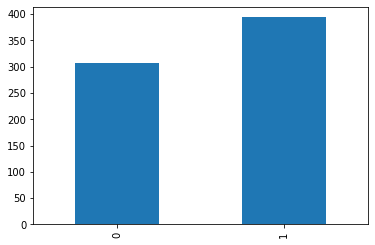

In [54]:
# Check for class imbalance
y.value_counts().sort_values().plot(kind = 'bar');

No class imbalance observed

## Logistic Regression with Lasso Penalty

**GridSearchCV for tuning Parameters**

In [55]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)

param_testing = {'C': [0.01,0.1,1.10]}

gr = GridSearchCV(LogisticRegression(penalty='l1', 
                                     solver='liblinear',  
                                     tol=0.0001, 
                                     max_iter=10000, 
                                     intercept_scaling=1.0, 
                                     multi_class='auto', 
                                     random_state=42),
                  param_testing,
                  verbose = 1,
                  scoring='accuracy',
                  cv = skf)

    
gr.fit(X_train,y_train)
print(gr.best_params_, gr.best_score_)
best_estimator = gr.best_estimator_
best_estimator

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.9min finished


{'C': 1.1} 0.7567140600315956


LogisticRegression(C=1.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1.0, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

**Run the Model**

In [56]:
lr = LogisticRegression(C = 1.1,
                          penalty='l1', 
                          solver='liblinear',  
                          tol=0.0001, 
                          max_iter=10000, 
                          intercept_scaling=1.0, 
                          multi_class='auto', 
                          random_state=42)


# Test Score
final_score = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr.fit(X_train,y_train)
    predictions = lr.predict(X_test)
    final_score.append(accuracy_score(y_test, predictions))
    print("Accuracy Score:" ,accuracy_score(y_test, predictions))    
    
logistic_test = np.mean(final_score)

# Train Score
final_score_train = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr.fit(X_train,y_train)
    predictions = lr.predict(X_train)
    final_score_train.append(accuracy_score(y_train, predictions))
    print("Accuracy Score:" ,accuracy_score(y_train, predictions))
    
logistic_train = np.mean(final_score_train)

Fold: 1
Accuracy Score: 0.8028169014084507
Fold: 2
Accuracy Score: 0.7746478873239436
Fold: 3
Accuracy Score: 0.7464788732394366
Fold: 4
Accuracy Score: 0.7323943661971831
Fold: 5
Accuracy Score: 0.8142857142857143
Fold: 6
Accuracy Score: 0.6428571428571429
Fold: 7
Accuracy Score: 0.7428571428571429
Fold: 8
Accuracy Score: 0.7714285714285715
Fold: 9
Accuracy Score: 0.8115942028985508
Fold: 10
Accuracy Score: 0.7101449275362319
Fold: 1
Accuracy Score: 0.7654516640253566
Fold: 2
Accuracy Score: 0.7591125198098256
Fold: 3
Accuracy Score: 0.7812995245641838
Fold: 4
Accuracy Score: 0.7717908082408875
Fold: 5
Accuracy Score: 0.7610759493670886
Fold: 6
Accuracy Score: 0.7768987341772152
Fold: 7
Accuracy Score: 0.7642405063291139
Fold: 8
Accuracy Score: 0.7721518987341772
Fold: 9
Accuracy Score: 0.7630331753554502
Fold: 10
Accuracy Score: 0.7756714060031595


**Plot test accuracy vs. train accuracy**

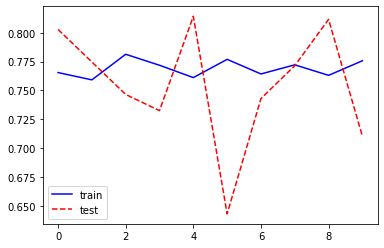

In [57]:
fig, ax = plt.subplots()
ax.plot(final_score_train, '-b', label='train')
ax.plot(final_score, '--r', label='test')
leg = ax.legend();

Although our mean train and test error rates are pretty close. Test error has high variance. We have only tuned lambda parameter as requested in the question with GridSearchCV and used a c value of 1.1. The high variance could be due to the noise in our training data.Also, it could be due to need of scaling/normalization in our data. We were able to predict %75 of the classes from test data shown by our mean accuracy score. Mean values of train and test scores are almost the same so we can say no overfitting.

# Decision Tree

**GridSearchCV for tuning Parameters**

In [58]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)

# We will try these parameters seperately because when tried together they do not give the best result
param_testing_depth = {'max_depth':np.arange(1,100,1)}  
# {'max_depth': 4} 0.7061611374407583
param_testing_minsamples = {'min_samples_leaf':np.arange(1,100,1)}  ,
# {'min_samples_leaf': 26} 0.7124802527646129

gr = GridSearchCV(DecisionTreeClassifier(random_state=42, max_depth=4,min_samples_leaf = 26),
                  param_testing_minsamples,
                  verbose = 1,
                  scoring='accuracy',
                  cv = skf)

    
gr.fit(X_train,y_train)
print(gr.best_params_, gr.best_score_)
best_estimator = gr.best_estimator_
best_estimator

Fitting 10 folds for each of 99 candidates, totalling 990 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'min_samples_leaf': 29} 0.7109004739336493


[Parallel(n_jobs=1)]: Done 990 out of 990 | elapsed:    6.0s finished


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=29, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

**Run the Model**

In [59]:
dt = DecisionTreeClassifier(random_state=42,max_depth=4,min_samples_leaf = 26)


# Test Score
final_score = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt.fit(X_train,y_train)
    predictions = dt.predict(X_test)
    final_score.append(accuracy_score(y_test, predictions))
    print("Accuracy Score:" ,accuracy_score(y_test, predictions))    
    
decision_test = np.mean(final_score)

# Train Score
final_score_train = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt.fit(X_train,y_train)
    predictions = dt.predict(X_train)
    final_score_train.append(accuracy_score(y_train, predictions))
    print("Accuracy Score:" ,accuracy_score(y_train, predictions))
    
decision_train = np.mean(final_score_train)

Fold: 1
Accuracy Score: 0.7464788732394366
Fold: 2
Accuracy Score: 0.7605633802816901
Fold: 3
Accuracy Score: 0.6901408450704225
Fold: 4
Accuracy Score: 0.7464788732394366
Fold: 5
Accuracy Score: 0.7
Fold: 6
Accuracy Score: 0.6142857142857143
Fold: 7
Accuracy Score: 0.6285714285714286
Fold: 8
Accuracy Score: 0.6
Fold: 9
Accuracy Score: 0.7536231884057971
Fold: 10
Accuracy Score: 0.7681159420289855
Fold: 1
Accuracy Score: 0.7496038034865293
Fold: 2
Accuracy Score: 0.7559429477020603
Fold: 3
Accuracy Score: 0.7480190174326465
Fold: 4
Accuracy Score: 0.7606973058637084
Fold: 5
Accuracy Score: 0.7420886075949367
Fold: 6
Accuracy Score: 0.7531645569620253
Fold: 7
Accuracy Score: 0.7658227848101266
Fold: 8
Accuracy Score: 0.75
Fold: 9
Accuracy Score: 0.7345971563981043
Fold: 10
Accuracy Score: 0.7503949447077409


**Plot test accuracy vs. train accuracy**

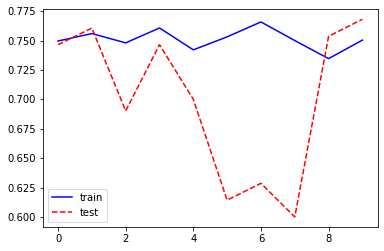

In [60]:
fig, ax = plt.subplots()
ax.plot(final_score_train, '-b', label='train')
ax.plot(final_score, '--r', label='test')
leg = ax.legend();

Our mean train accuracy is 0.75 whereas our mean test accuracy is 0.71. Test error has high variance again. The high variance could be due to the noise in our training data. However, since tree based models are not affected by scaling it is not due to neeed for scaling. We were able to predict %71 of the classes from test data shown by our mean accuracy score. This is comparably less than our LogisticRegression Scores. There is no indication of overfitting or underfitting for test set since the accuracy scores jump up and down. There could be slight over fitting for train data looking at the scores over the 10 folds for test and train data.

# Random Forest

**GridSearchCV for tuning Parameters**

In [61]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)

# only asked to tune number of features to do a split
# Max_features should be between 0,n_features(We have 14 features)
param_testing_m = {'max_features':np.arange(1,14,1)}  
# {'max_features': 3} 0.740916271721959


gr = GridSearchCV(RandomForestClassifier(max_depth=9, 
                                              random_state=0,
                                              min_samples_leaf = 5,
                                              n_estimators = 500)
                  ,param_testing_m,
                  verbose = 1,
                  scoring='accuracy',
                  cv = skf)

    
gr.fit(X_train,y_train)
print(gr.best_params_, gr.best_score_)
best_estimator = gr.best_estimator_
best_estimator

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:  2.2min finished


{'max_features': 4} 0.7377567140600316


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

**Run the Model**

In [62]:
rf = RandomForestClassifier(max_depth=9, random_state=0,min_samples_leaf = 5,n_estimators = 500,max_features = 3)


# Test Score
final_score = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf.fit(X_train,y_train)
    predictions = rf.predict(X_test)
    final_score.append(accuracy_score(y_test, predictions))
    print("Accuracy Score:" ,accuracy_score(y_test, predictions))    
    
random_test = np.mean(final_score)

# Train Score
final_score_train = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf.fit(X_train,y_train)
    predictions = rf.predict(X_train)
    final_score_train.append(accuracy_score(y_train, predictions))
    print("Accuracy Score:" ,accuracy_score(y_train, predictions))
    
random_train = np.mean(final_score_train)

Fold: 1
Accuracy Score: 0.7464788732394366
Fold: 2
Accuracy Score: 0.7887323943661971
Fold: 3
Accuracy Score: 0.6901408450704225
Fold: 4
Accuracy Score: 0.676056338028169
Fold: 5
Accuracy Score: 0.7714285714285715
Fold: 6
Accuracy Score: 0.6571428571428571
Fold: 7
Accuracy Score: 0.6857142857142857
Fold: 8
Accuracy Score: 0.6571428571428571
Fold: 9
Accuracy Score: 0.8260869565217391
Fold: 10
Accuracy Score: 0.7536231884057971
Fold: 1
Accuracy Score: 0.8748019017432647
Fold: 2
Accuracy Score: 0.8779714738510301
Fold: 3
Accuracy Score: 0.8874801901743264
Fold: 4
Accuracy Score: 0.8700475435816165
Fold: 5
Accuracy Score: 0.8781645569620253
Fold: 6
Accuracy Score: 0.8765822784810127
Fold: 7
Accuracy Score: 0.8829113924050633
Fold: 8
Accuracy Score: 0.8876582278481012
Fold: 9
Accuracy Score: 0.8783570300157978
Fold: 10
Accuracy Score: 0.8846761453396524


**Plot test accuracy vs. train accuracy**

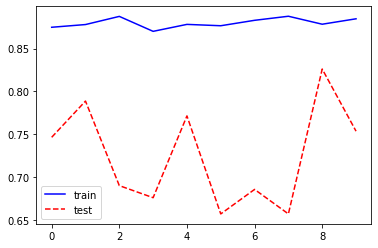

In [63]:
fig, ax = plt.subplots()
ax.plot(final_score_train, '-b', label='train')
ax.plot(final_score, '--r', label='test')
leg = ax.legend();

Our mean train accuracy is 0.86 whereas our mean test accuracy is 0.74. Test error has high variance again. The high variance could be due to the noise in our training data. However, since tree based models are not affected by scaling it is not due to neeed for scaling. For this we can say our model overfitted the train data which can be expected because we have about ~600 lines of data. And overfitting is expected for such small data.

# Stochastic Gradient Boosting (SGB):

**GridSearchCV for tuning Parameters**

In [64]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)



param_testing_depth = {'max_depth':np.arange(1,14,1)}  
# {'max_depth': 2} 0.7282780410742496
param_testing_trees = {'n_estimators':np.arange(300,500,50)}
# {'n_estimators': 350} 0.7456556082148499
param_testing_learning = {'learning_rate':np.arange(0.01,0.1,0.05)} 
# {'learning_rate': 0.01} 0.7456556082148499



gr = GridSearchCV(GradientBoostingClassifier(random_state=42,max_depth = 2,n_estimators = 350)
                  ,param_testing_learning,
                  verbose = 1,
                  scoring='accuracy',
                  cv = skf)

    
gr.fit(X_train,y_train)
print(gr.best_params_, gr.best_score_)
best_estimator = gr.best_estimator_
best_estimator

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.1s finished


{'learning_rate': 0.01} 0.7424960505529226


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=350,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

**Run the Model**

In [65]:
gb = GradientBoostingClassifier(random_state=42,max_depth = 2,n_estimators = 350, learning_rate = 0.01)


# Test Score
final_score = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    gb.fit(X_train,y_train)
    predictions = gb.predict(X_test)
    final_score.append(accuracy_score(y_test, predictions))
    print("Accuracy Score:" ,accuracy_score(y_test, predictions))    
    
gradient_test = np.mean(final_score)

# Train Score
final_score_train = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    gb.fit(X_train,y_train)
    predictions = gb.predict(X_train)
    final_score_train.append(accuracy_score(y_train, predictions))
    print("Accuracy Score:" ,accuracy_score(y_train, predictions))
    
gradient_train = np.mean(final_score_train)

Fold: 1
Accuracy Score: 0.8169014084507042
Fold: 2
Accuracy Score: 0.7887323943661971
Fold: 3
Accuracy Score: 0.676056338028169
Fold: 4
Accuracy Score: 0.7183098591549296
Fold: 5
Accuracy Score: 0.8428571428571429
Fold: 6
Accuracy Score: 0.6142857142857143
Fold: 7
Accuracy Score: 0.7
Fold: 8
Accuracy Score: 0.6714285714285714
Fold: 9
Accuracy Score: 0.7971014492753623
Fold: 10
Accuracy Score: 0.7536231884057971
Fold: 1
Accuracy Score: 0.7844690966719493
Fold: 2
Accuracy Score: 0.7923930269413629
Fold: 3
Accuracy Score: 0.7908082408874801
Fold: 4
Accuracy Score: 0.7797147385103012
Fold: 5
Accuracy Score: 0.7863924050632911
Fold: 6
Accuracy Score: 0.805379746835443
Fold: 7
Accuracy Score: 0.7911392405063291
Fold: 8
Accuracy Score: 0.7895569620253164
Fold: 9
Accuracy Score: 0.7867298578199052
Fold: 10
Accuracy Score: 0.7851500789889415


In [66]:
gradient_train

0.789173339425032

In [67]:
gradient_test

0.7379296066252589

**Plot test accuracy vs. train accuracy**

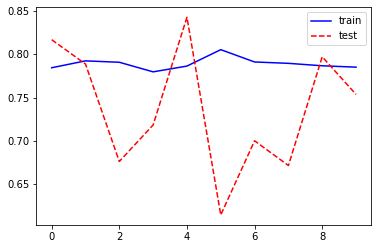

In [68]:
fig, ax = plt.subplots()
ax.plot(final_score_train, '-b', label='train')
ax.plot(final_score, '--r', label='test')
leg = ax.legend();

Our mean train accuracy is 0.78 whereas our mean test accuracy is 0.73. Test error has high variance as usual. The high variance could be due to the noise in our training data. For this we can say our model overfitted the train data which can be expected because we have about ~600 lines of data. And overfitting is expected for such small data for complex models

**Let's compare the results from all algorithms**

In [69]:
# Add train and test scores for all Algorithms
classification_algorithm_df = pd.DataFrame(data = {"train":[logistic_train,decision_train,random_train,gradient_train],
                                                   "test":[logistic_test,decision_test,random_test,gradient_test]})
classification_algorithm_df.index = ["LogisticRegression","DecisionTree","RandomForest","GradientBoosting"]
classification_algorithm_df

,train,test
LogisticRegression,0.769073,0.754951
DecisionTree,0.751033,0.700826
RandomForest,0.879865,0.725255
GradientBoosting,0.789173,0.737930


We see that Logistic Regression with Lasso penalty has the highest test accuracy which is expected because our data size is very small about 600 rows that is why the complex models are expected to overfit and produce lower accuracy on test data.

## 1.Regression - <span style="color:gray"> Predict the total number of goals</span>

**Import Packages**

In [72]:
# Import some additional packages
from sklearn.metrics import mean_squared_error
from yellowbrick.regressor import AlphaSelection
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from yellowbrick.regressor import ManualAlphaSelection

**Create column total number of goals**

In [73]:
matches["total"] = matches["home_score"] + matches["away_score"]

**Set X(features) and y(target) variables**

In [74]:
X = matches.drop(['match_id','match_status',
       'match_live', 'match_hometeam_name', 'match_awayteam_name',
       'home_score', 'away_score', 'match_hometeam_halftime_score',
       'match_awayteam_halftime_score', 'match_hometeam_extra_score',
       'match_awayteam_extra_score', 'match_hometeam_penalty_score',
       'match_awayteam_penalty_score', 'league_id', 'datetime', 'Date', 'Time',
       'match_result',"home_points","away_points","total"], axis = 1)

y = matches["total"]

# Algorithms

# LassoCV

**GridSearchCV for tuning Parameters**

In [75]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)



param_testing = {'alpha': [0.01,0.1,1.10]}
# {'alpha': 0.01} -0.38093438179085426

gr = GridSearchCV(Lasso( random_state=42),
                  param_testing,
                  verbose = 1,
                  scoring='neg_mean_absolute_error',
                  cv = skf)

    
gr.fit(X_train,y_train)
print(gr.best_params_, gr.best_score_)
best_estimator = gr.best_estimator_
best_estimator

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished


{'alpha': 0.01} -0.3809343817908542


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

**Run the Model**

In [76]:
lr = Lasso(alpha=0.01, random_state=42)


# Test Score
final_score = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr.fit(X_train,y_train)
    predictions = lr.predict(X_test)
    final_score.append(mean_absolute_error(y_test, predictions))
    print("MAE Score:" ,mean_absolute_error(y_test, predictions))    
    
lasso_test = np.mean(final_score)

# Train Score
final_score_train = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr.fit(X_train,y_train)
    predictions = lr.predict(X_train)
    final_score_train.append(mean_absolute_error(y_train, predictions))
    print("MAE Score:" ,mean_absolute_error(y_train, predictions))
    
lasso_train = np.mean(final_score_train)

Fold: 1
MAE Score: 0.00552613204299467
Fold: 2
MAE Score: 0.005570496704664072
Fold: 3
MAE Score: 0.005170285090474072
Fold: 4
MAE Score: 0.004807931286665127
Fold: 5
MAE Score: 0.004721706890118244
Fold: 6
MAE Score: 0.004772463730862663
Fold: 7
MAE Score: 0.004788863295688904
Fold: 8
MAE Score: 0.004722224930947511
Fold: 9
MAE Score: 0.004834967880335945
Fold: 10
MAE Score: 0.004473035977823363
Fold: 1
MAE Score: 0.005055286853573722
Fold: 2
MAE Score: 0.005064966768527265
Fold: 3
MAE Score: 0.0049512752446582665
Fold: 4
MAE Score: 0.004904971586086432
Fold: 5
MAE Score: 0.0049058130177048066
Fold: 6
MAE Score: 0.00490982275414021
Fold: 7
MAE Score: 0.004910324672172237
Fold: 8
MAE Score: 0.004916126847717779
Fold: 9
MAE Score: 0.004908901274765059
Fold: 10
MAE Score: 0.004890036136471974


In [77]:
lasso_train

0.004941752515581775

In [78]:
lasso_test

0.0049388107830574575

**Plot test accuracy vs. train accuracy**

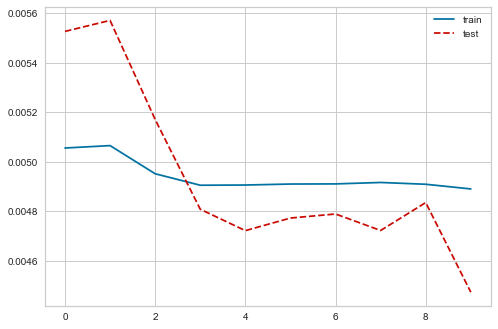

In [79]:
fig, ax = plt.subplots()
ax.plot(final_score_train, '-b', label='train')
ax.plot(final_score, '--r', label='test')
leg = ax.legend();

Our average train score is 0.99 and test score is 1.01. They are very close however test scores have high variance. And overfitting/underfitting situation changes from fold to fold. For example for fold 1 train data is underfitted but for fold 
7 train data is overfitted.

# Decision Tree

**GridSearchCV for tuning Parameters**

In [80]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)

# We will try these parameters seperately because when tried together they do not give the best result
param_testing_depth = {'max_depth':np.arange(1,100,1)}  
# {'max_depth': 4} -0.0330188679245283
param_testing_minsamples = {'min_samples_leaf':np.arange(1,100,1)}  ,
# {'min_samples_leaf': 1} -0.0330188679245283

gr = GridSearchCV(DecisionTreeClassifier(random_state=42,max_depth = 4),
                  param_testing_minsamples,
                  verbose = 1,
                  scoring='neg_mean_absolute_error',
                  cv = skf)

    
gr.fit(X_train,y_train)
print(gr.best_params_, gr.best_score_)
best_estimator = gr.best_estimator_
best_estimator

Fitting 10 folds for each of 99 candidates, totalling 990 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'min_samples_leaf': 1} -0.0330188679245283


[Parallel(n_jobs=1)]: Done 990 out of 990 | elapsed:    5.4s finished


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

**Run the Model**

In [81]:
dt = DecisionTreeClassifier(random_state=42,max_depth=4,min_samples_leaf = 1)


# Test Score
final_score = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt.fit(X_train,y_train)
    predictions = dt.predict_proba(X_test)[:,1]
    final_score.append(mean_absolute_error(y_test, predictions))
    print("MAE Score:" ,mean_absolute_error(y_test, predictions))    
    
decision_test = np.mean(final_score)

# Train Score
final_score_train = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt.fit(X_train,y_train)
    predictions = dt.predict_proba(X_train)[:,1]
    final_score_train.append(mean_absolute_error(y_train, predictions))
    print("MAE Score:" ,mean_absolute_error(y_train, predictions))
    
decision_train = np.mean(final_score_train)

Fold: 1
MAE Score: 2.8157894736842106
Fold: 2
MAE Score: 2.8157894736842106
Fold: 3
MAE Score: 2.7432432432432434
Fold: 4
MAE Score: 2.7
Fold: 5
MAE Score: 2.6956521739130435
Fold: 6
MAE Score: 2.6956521739130435
Fold: 7
MAE Score: 2.661764705882353
Fold: 8
MAE Score: 2.6417910447761193
Fold: 9
MAE Score: 2.6417910447761193
Fold: 10
MAE Score: 2.5757575757575757
Fold: 1
MAE Score: 2.6884984025559104
Fold: 2
MAE Score: 2.6884984025559104
Fold: 3
MAE Score: 2.6974522292993632
Fold: 4
MAE Score: 2.7025316455696204
Fold: 5
MAE Score: 2.703001579778831
Fold: 6
MAE Score: 2.703001579778831
Fold: 7
MAE Score: 2.7066246056782335
Fold: 8
MAE Score: 2.7086614173228347
Fold: 9
MAE Score: 2.7086614173228347
Fold: 10
MAE Score: 2.7154088050314464


**Plot test accuracy vs. train accuracy**

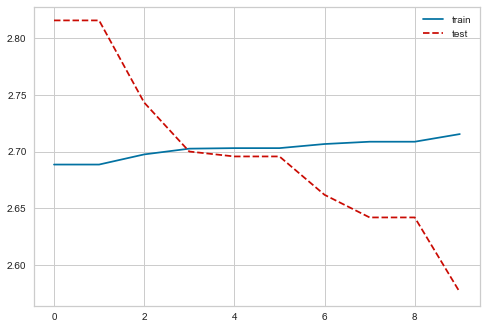

In [82]:
fig, ax = plt.subplots()
ax.plot(final_score_train, '-b', label='train')
ax.plot(final_score, '--r', label='test')
leg = ax.legend();

Our mean train and test error rates are very close. Test error has high variance. We have only tuned max_depth and minimum samples in a leaf parameters  as requested in the question with GridSearchCV.The high variance could be due to the noise in our training data. Since most of the test scores are below out of 10 folds there is an inclination to overfitting for train data from fold 4-10.

# Random Forest

**GridSearchCV for tuning Parameters**

In [83]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)

# only asked to tune number of features to do a split
# Max_features should be between 0,n_features(We have 14 features)
param_testing_m = {'max_features':np.arange(1,14,1)}  
# {'max_features': 11} 0.9921383647798742


gr = GridSearchCV(RandomForestClassifier(max_depth=9, 
                                              random_state=0,
                                              min_samples_leaf = 5,
                                              n_estimators = 500)
                  ,param_testing_m,
                  verbose = 1,
                  scoring='accuracy',
                  cv = skf)

    
gr.fit(X_train,y_train)
print(gr.best_params_, gr.best_score_)
best_estimator = gr.best_estimator_
best_estimator

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:  2.1min finished


{'max_features': 13} 0.9858490566037735


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features=13, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

**Run the Model**

In [84]:
rf = RandomForestClassifier(max_depth=9, random_state=0,min_samples_leaf = 5,n_estimators = 500,max_features = 11)


# Test Score
final_score = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf.fit(X_train,y_train)
    predictions = rf.predict_proba(X_test)[:,1]
    final_score.append(mean_absolute_error(y_test, predictions))
    print("MAE Score:" ,mean_absolute_error(y_test, predictions))    
    
random_test = np.mean(final_score)

# Train Score
final_score_train = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf.fit(X_train,y_train)
    predictions = rf.predict_proba(X_train)[:,1]
    final_score_train.append(mean_absolute_error(y_train, predictions))
    print("MAE Score:" ,mean_absolute_error(y_train, predictions))
    
random_train = np.mean(final_score_train)

Fold: 1
MAE Score: 2.8357534404736042
Fold: 2
MAE Score: 2.8387919809319038
Fold: 3
MAE Score: 2.7636000609396505
Fold: 4
MAE Score: 2.7188827827973467
Fold: 5
MAE Score: 2.717805193971212
Fold: 6
MAE Score: 2.7171072790006194
Fold: 7
MAE Score: 2.689732384295951
Fold: 8
MAE Score: 2.665303558773118
Fold: 9
MAE Score: 2.6708441255190345
Fold: 10
MAE Score: 2.5958355550066146
Fold: 1
MAE Score: 2.7052271106749495
Fold: 2
MAE Score: 2.7046043637762462
Fold: 3
MAE Score: 2.7139876028500076
Fold: 4
MAE Score: 2.7195765070087163
Fold: 5
MAE Score: 2.7199410125874097
Fold: 6
MAE Score: 2.7176636587873455
Fold: 7
MAE Score: 2.7223792818381356
Fold: 8
MAE Score: 2.7261866546590583
Fold: 9
MAE Score: 2.7249543985580305
Fold: 10
MAE Score: 2.7315553941287596


**Plot test accuracy vs. train accuracy**

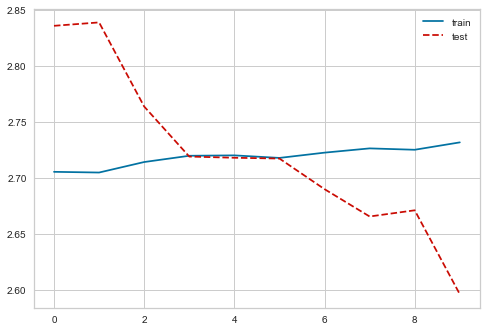

In [85]:
fig, ax = plt.subplots()
ax.plot(final_score_train, '-b', label='train')
ax.plot(final_score, '--r', label='test')
leg = ax.legend();

Our mean train score is 2.7 and our mean test accuracy is 2.7. Test error has high variance again. The high variance could be due to the noise in our training data. However, since tree based models are not affected by scaling it is not due to neeed for scaling. For this we can say our model overfitted the train data which can be expected because we have about ~600 lines of data. And overfitting is expected for such small data. Again can be seen for most folds model overfitted train data.

# Stochastic Gradient Boosting (SGB):

**GridSearchCV for tuning Parameters**

In [86]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)



param_testing_depth = {'max_depth':np.arange(1,14,1)}  
# {'max_depth': 1} 1.0
param_testing_trees = {'n_estimators':np.arange(300,500,50)}
# {'n_estimators': 300} 1.0
param_testing_learning = {'learning_rate':np.arange(0.01,0.1,0.05)} 
# {'learning_rate': 0.01} 1.0



gr = GridSearchCV(GradientBoostingClassifier(random_state=42, max_depth = 1, n_estimators = 300)
                  ,param_testing_learning,
                  verbose = 1,
                  scoring='accuracy',
                  cv = skf)

    
gr.fit(X_train,y_train)
print(gr.best_params_, gr.best_score_)
best_estimator = gr.best_estimator_
best_estimator

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   38.1s finished


{'learning_rate': 0.01} 1.0


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

**Run the Model**

In [87]:
gb = GradientBoostingClassifier(random_state=42,max_depth = 1,n_estimators = 350, learning_rate = 0.01)


# Test Score
final_score = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    gb.fit(X_train,y_train)
    predictions = gb.predict_proba(X_test)[:,1]
    final_score.append(mean_absolute_error(y_test, predictions))
    print("MAE Score:" ,mean_absolute_error(y_test, predictions))    
    
gradient_test = np.mean(final_score)

# Train Score
final_score_train = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    gb.fit(X_train,y_train)
    predictions = gb.predict_proba(X_train)[:,1]
    final_score_train.append(mean_absolute_error(y_train, predictions))
    print("MAE Score:" ,mean_absolute_error(y_train, predictions))
    
gradient_train = np.mean(final_score_train)

Fold: 1
MAE Score: 2.829147507596258
Fold: 2
MAE Score: 2.8291475075962573
Fold: 3
MAE Score: 2.757213200903954
Fold: 4
MAE Score: 2.7125010043015862
Fold: 5
MAE Score: 2.708469598666452
Fold: 6
MAE Score: 2.708469598666452
Fold: 7
MAE Score: 2.674916698137441
Fold: 8
MAE Score: 2.6552278574912114
Fold: 9
MAE Score: 2.655227857491211
Fold: 10
MAE Score: 2.5893980202425864
Fold: 1
MAE Score: 2.701500955858201
Fold: 2
MAE Score: 2.701500955858201
Fold: 3
MAE Score: 2.7105758649523386
Fold: 4
MAE Score: 2.715862601139398
Fold: 5
MAE Score: 2.7163139948263177
Fold: 6
MAE Score: 2.7163139948263177
Fold: 7
MAE Score: 2.720022070603466
Fold: 8
MAE Score: 2.7220344596571078
Fold: 9
MAE Score: 2.7220344596571078
Fold: 10
MAE Score: 2.72875222796747


**Plot test accuracy vs. train accuracy**

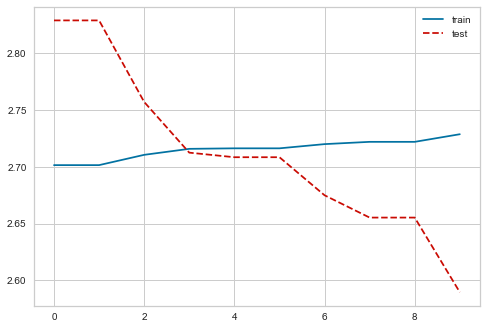

In [88]:
fig, ax = plt.subplots()
ax.plot(final_score_train, '-b', label='train')
ax.plot(final_score, '--r', label='test')
leg = ax.legend();

Train error and test error are the same. Again there is overfitting over some folds of cross validation for example for fold 1 our test set seems to be overfitting but for fold 8 train set is overfitting. Test scores have high variance

**Let's compare the results from all algorithms**

In [89]:
# Add train and test scores for all Algorithms
regression_algorithm_df = pd.DataFrame(data = {"train":[lasso_train,decision_train,random_train,gradient_train],
                                                   "test":[lasso_test,decision_test,random_test,gradient_test]})
regression_algorithm_df.index = ["Lasso","DecisionTree","RandomForest","GradientBoosting"]
regression_algorithm_df

,train,test
Lasso,0.004942,0.004939
DecisionTree,2.702234,2.698723
RandomForest,2.718608,2.721366
GradientBoosting,2.715491,2.711972


We see that Lasso Regression lowest error. Since we have a handful of data complex models werent expected to yield better results and they didn't. For classification and regression problems we have observed that a simple logistic regression model worked best. Models other than Lasso are very close in scores.There is still improvement for models especially with high variances of test sets even though the mean scores of test and train sets are very close. Options are to use a higher regularization, scale/normalize data,use a different metric... We have used accuracy for classification and mean absolute error for regression.Since our target is not imbalanced accuracy will work for us and give the ratio of true predictions to total predictions. We could have used RMSE for regression as a metric but it would not make a difference for our results. Since Lasso is the leading algorithm by far and the other are almost identical.